In [5]:
from players import *

In [ ]:
players = [Player("A" , 20 , 0 , 30 , 30 ,  ),
           Player("B" , 20)    ]

In [7]:
class CustomPlayer(Player):
    
    @classmethod
    def dummyPlayer(cls , name , dodgeChance):
        return cls(name , 20 , 0 , 30 , 30 , dodgeChance)
    
names = "ABC"
dodgeChances = [0.1, 0.2 , 0.3]
combatants = [CustomPlayer.dummyPlayer(name , dodge) for name , dodge in zip(names,dodgeChances)]
combatants

2022-07-16 13:40:48,914:Player A has been instantiated!
2022-07-16 13:40:48,917:Player B has been instantiated!
2022-07-16 13:40:48,918:Player C has been instantiated!


[CustomPlayer(name='A', health=20.0, armor=0.0, lower_damage=30.0, upper_damage=30.0, dodge_chance=0.1, max_health=20.0, target=None),
 CustomPlayer(name='B', health=20.0, armor=0.0, lower_damage=30.0, upper_damage=30.0, dodge_chance=0.2, max_health=20.0, target=None),
 CustomPlayer(name='C', health=20.0, armor=0.0, lower_damage=30.0, upper_damage=30.0, dodge_chance=0.3, max_health=20.0, target=None)]

In [9]:
Game().start(combatants)

2022-07-16 13:41:45,950:Game has been initialized!
2022-07-16 13:41:45,951:A stares aggresively at B.
2022-07-16 13:41:45,952:B stares aggresively at C.
2022-07-16 13:41:45,953:C stares aggresively at A.
2022-07-16 13:41:45,954:************************* Round 1 *************************
2022-07-16 13:41:45,955:Player A strikes B for 30.00 damage (physical)!
2022-07-16 13:41:45,955:Player B has deceased :(
2022-07-16 13:41:45,956:Player B strikes C for 30.00 damage (physical)!
2022-07-16 13:41:45,957:Player C has deceased :(
2022-07-16 13:41:45,958:Player C strikes A for 30.00 damage (physical)!
2022-07-16 13:41:45,959:Player A has deceased :(
2022-07-16 13:41:45,960:************************* Round 2 *************************
2022-07-16 13:41:45,962:Game has ended in rounds=2!
2022-07-16 13:41:45,963:The game ended in a DRAW!


In [171]:
from dataclasses import dataclass , field
import sys
from typing import Union , ClassVar

class ImmutableList(type):
    
    def __setattr__(cls , name , val):
        if name in ["damage","max_health"]:
            raise AttributeError(f"Trying to mutate immutable attribute {name}.")
        else:
            return type.__setattr__(cls , name , value)
            

@dataclass(slots=True)
class Player:
    
    __metaclass__ = ImmutableList
    name : str
    health : float
    max_health : float = field(init = False)
    damage : float = field(init = False , default = sys.maxsize)
    dodge_chance : float
    target : Union[None , Player] = field(init = False , default = None , repr = False)
    players : ClassVar[dict[str,Player]] = {}
    
    def __post_init__(self):
        self.max_health = self.health
        Player.players.update({self.name : self})
        
    def is_alive(self):
        return self.health > 0
    
    def resurrect(self):
        self.health = self.max_health
    
    def set_target(self , other):
        self.target = other
        
    def attack(self):
        if self.target is None:
            raise TypeError("Have yet to define a valid target")
        
        if random.random() <= self.dodge_chance:
            self.target.health -= self.damage
        
    @classmethod
    def producePlayer(cls , name , dodge_chance):
        return cls(name , 100 , dodge_chance)

In [172]:
player_one = Player.producePlayer("Nicole",0.1)

In [173]:
player_two = Player.producePlayer("Alice",0.2)

In [174]:
import logging

def start_game(players):
    
    idx = 0
    players[0].set_target(players[1])
    players[1].set_target(players[0])
    while True:
        
        players[idx%len(players)].attack()
        
        if not players[(idx+1)%len(players)].is_alive():
            break
        else:
            idx += 1
            
    for player in players:
        player.resurrect()
        
    return idx%len(players)
        

In [175]:
start_game([player_one, player_two])

0

In [176]:
player_one

Player(name='Nicole', health=100, max_health=100, damage=9223372036854775807, dodge_chance=0.1)

In [177]:
import numpy as np

total_epochs = 1000
dodge_chances = np.arange(0.1 , 1.0 , 0.025)
winning_stats = {}
for x_chance in dodge_chances:
    for y_chance in dodge_chances:
        players = [Player.producePlayer("Nicole",x_chance) , 
                   Player.producePlayer("Bob",y_chance)]
        winning_stats[ (x_chance , y_chance) ] = 0
        for epoch in range(total_epochs):
            winning_stats[ (x_chance , y_chance) ] += 1 - start_game(players)
        winning_stats[ (x_chance , y_chance)] /= total_epochs

Consider two players hitting at each other. Let $a$ the probability of Bob hitting Alice in a sequential duel. Let $p$ denote the probability of win for player Bob.

\begin{equation}
\begin{split}
P ( \text{Alice wins} ) & = \sum_{round=1}^{\infty} a (1-a)^{round-1} (1-b)^{round-1} \\ 
                        & = \frac{a}{1 - (1-a)(1-b)} \\
P ( \text{Bob wins} ) & = \sum_{round=1}^{\infty} b ( 1 - a )^{round} (1-b)^{round-1} \\
                      & = \frac{b(1-a)}{1 - (1-a)(1-b)} \\
\end{split}
\end{equation}

\begin{equation}
\begin{split}
& P ( \text{Alice wins} ) > P ( \text{Bob wins} ) \\
& \frac{a}{1 - (1-a)(1-b)} > \frac{b(1-a)}{1 - (1-a)(1-b)} \\
& \frac{a}{1-a} > b \\
& a - b + a b > 0
\end{split}
\end{equation}

Notice that if $a/(1-a) > 1$, or equivalently, $a > 0.5$, then the probability of Alice winning is always greater than the probability of Bob winning the paintball duel, since $1 > b$ always strictly.

In [178]:
def prob_alice_wins(a,b):
    return a/(a + b - a*b)

def prob_bob_wins(a,b):
    return 1 - prob_alice_wins(a,b)

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

In [180]:
players = [Player.producePlayer("Nicole",0.4), 
           Player.producePlayer("Bob",0.6)]

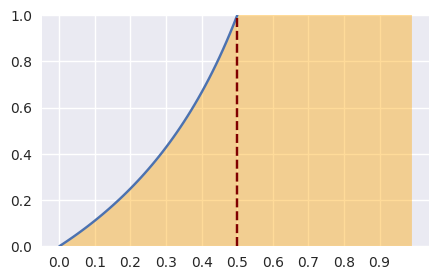

In [181]:
a = np.linspace(0.0001 , 0.99 , 100)
b = lambda a : a/(1-a)

with plt.style.context("seaborn"):
    fig , ax = plt.subplots(nrows = 1 , ncols = 1 , figsize = (5,3))
    ax.plot(a , b(a))
    ax.fill_between(a,b(a),color="orange",alpha = 0.4)
    ax.axvline(0.5 , color = "maroon" , linestyle = '--')
    ax.set_ylim(0,1)
    ax.set_xticks(np.arange(0.0,1,0.1))

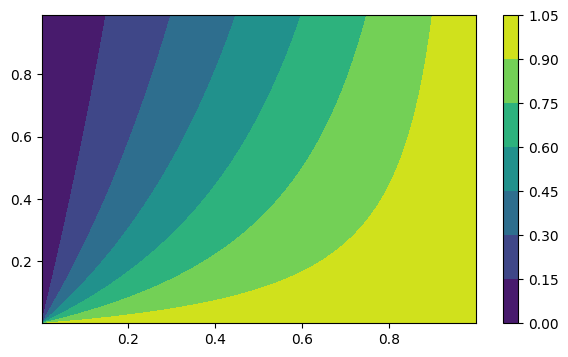

In [182]:
def func(a,b):
    return a/(a+b-a*b)

X , Y = np.meshgrid( np.linspace(0.001,0.999,100) , np.linspace(0.001,0.99,100))
Z = func(X,Y)
fig , ax = plt.subplots(nrows = 1 , ncols = 1 , figsize = (7,4))
cs_ = ax.contourf(X , Y , Z);
fig.colorbar(cs_);

In [212]:
import logging

class Beliefs:
    
    def __init__(self):
        self.a = 1
        self.b = 1
    
    def _beliefs(self):
        return lambda x : beta(self.a,self.b).pdf(x)
    
    def update(self , results : list):
        self.a += sum(results)
        self.b += len(results) - sum(results)
        
    def plot(self , figsize = (4,3)):
        xs = np.linspace(0.001,0.999,100)
        with plt.style.context("seaborn"):
            fig , ax = plt.subplots(nrows = 1 , ncols = 1 , figsize = figsize)
            ax.plot( xs , self._beliefs()(xs) )
            estimator = self._bayes_estimator()
            ax.axvline( estimator , color = 'maroon' , linestyle = '--')
            ax.annotate( xy = ( estimator , self._beliefs()(estimator)) , 
                         text = "%1.2f" % estimator,
                         color = 'seagreen')
            return fig
        
    def _bayes_estimator(self) -> float:
        return (self.a)/(self.a + self.b)
        
    def predict(self) -> int:
        return int(self._bayes_estimator >= 0.5)
    
    def reset(self) -> None:
        self.a = self.b = 1
        logging.info("Beliefs have been reset!")

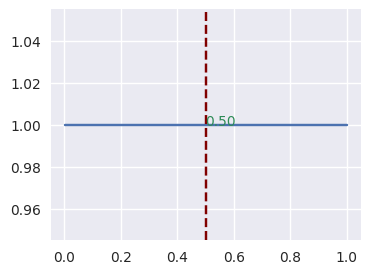

In [213]:
beliefs = Beliefs()
beliefs.plot();

In [214]:
players = [Player.producePlayer("Alice", 0.6),
           Player.producePlayer("Bob",0.4)]

In [215]:
results = [start_game(players) for _ in range(10000)]
prob_alice = sum(results)/len(results)
prob_bob = 1 - prob_alice
prob_alice , prob_bob

(0.21, 0.79)

In [235]:
prob_alice_wins(0.6,0.4)

0.7894736842105263

In [240]:
beliefs = Beliefs()
results = [1 - start_game(players) for _ in range(20)]
beliefs.update(results)

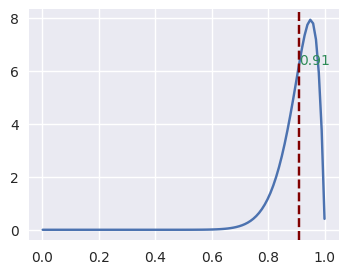

In [241]:
beliefs.plot();

In [242]:
class Bot(Player):
    
    def set_target(self , adversaries : list[Player]):
        target = max(adversaries , key = lambda player : player.dodge_chance)
        super().set_target(target)
    
class TargetProtocol:
    
    def __init__(self , players : list[Player]):
        self.players = players
        
    def get_alive_players(self):
        return filter(lambda player : player.is_alive() , self.players)
        
    def find_opponents(player : Player) -> list[Player]:
        return [adversary for adversary in self.get_alive_players() if adversary is not player]
    
    def protocol(self):
        for player in self.get_alive_players():
            adversaries = self.find_opponents(player)
            player.set_target(adversaries)

In [146]:
players

[Player(name='Nicole', health=100, max_health=100, damage=9223372036854775807, dodge_chance=0.9749999999999998, target=Player(name='Bob', health=100, max_health=100, damage=9223372036854775807, dodge_chance=0.9749999999999998, target=...)),
 Player(name='Bob', health=100, max_health=100, damage=9223372036854775807, dodge_chance=0.9749999999999998, target=Player(name='Nicole', health=100, max_health=100, damage=9223372036854775807, dodge_chance=0.9749999999999998, target=...))]